In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker
import sectionate
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client
import glob
import cmocean.cm as cmo
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

print(f"Sectionate version: {sectionate.__version__}")
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

Sectionate version: 0.2.1
xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [3]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/" + x
datafiles = glob.glob(datadir("CM4Xp125*"))[20:]
datafiles = sorted(datafiles)[26:32]

In [16]:
get_transports = lambda ds: ds[["umo", "vmo", "thkcello", "sigma2_i"]]
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        # datadir("model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_*.zarr"),
        datafiles[1],
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        preprocess = get_transports, 
        engine="zarr")
ds = ds.fillna(0.0)
# ds = ds.where(ds.thkcello > 0)/

In [ ]:
vmo.where(thk_cumsum > 0)

In [40]:
grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")

#time mean velocity and thickenss
vmo  = ds['vmo'].mean(dim='time')
thk  = ds['thkcello'].mean(dim='time', skipna = True)
thk_cumsum = thk.cumsum(dim='sigma2_l')
#estimate depth

zrho = thk.cumsum(dim='sigma2_l').mean(dim='xh') #don't mask land cells
# zrho_masked = thk.where(thk > 0).cumsum(dim='sigma2_l').mean(dim='xh') #mask land cells
zrho_masked = thk_cumsum.where(thk_cumsum > 0).mean(dim='xh', skipna=True) #mask land cells

vmo_xsum = vmo.sum(dim='xh', skipna = True) 
psi      = (vmo_xsum.cumsum(dim='sigma2_l') - vmo_xsum.sum(dim='sigma2_l'))/1e9 
psi.name = 'meridional-sigma2 overturning'

# defined by zonal mean of the time mean depth of rho
psi.coords['depth'] = grid.interp(zrho, 'Y', boundary='extend')
psi.coords['depth_masked'] = grid.interp(zrho_masked, 'Y', boundary='extend')

psi.coords['geolat'] = ds["geolat_v"].mean(dim='xh')

psi = psi.compute()

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


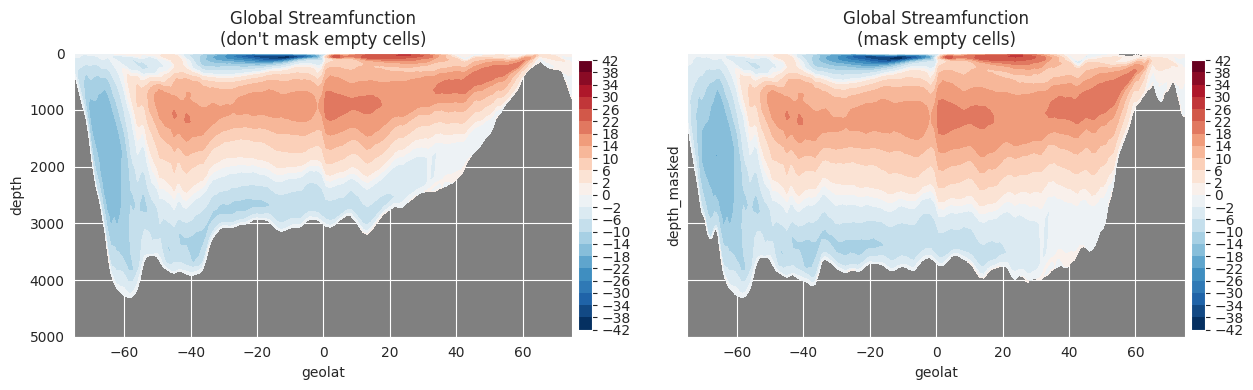

In [42]:
#define streamfunction levels
levels = [-42, -38, -34, -30, -26, -22, -18, -14, -10, -6, -2, 
           0,   2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42]

#select experiment 
exp = "control"

# create one figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=True)

# first subplot: depth
ax = axes[0]
p1 = psi.sel(exp=exp).plot.contourf(
    ax=ax, x="geolat", y="depth", levels=levels,
    add_colorbar=False, cmap='RdBu_r'
)
c1 = fig.colorbar(p1, ax=ax, pad=0.01, spacing='uniform',
                  extend='both', shrink=0.95, orientation='vertical')
c1.set_ticks(levels)
c1.ax.tick_params(labelsize=10)
ax.set_facecolor('gray')
ax.set_xlim(-75, 75)
ax.set_ylim(0, 5000)
ax.invert_yaxis()
ax.set_title("Global Streamfunction\n(don't mask empty cells)")

# second subplot: depth_masked
ax = axes[1]
p2 = psi.sel(exp=exp).plot.contourf(
    ax=ax, x="geolat", y="depth_masked", levels=levels,
    add_colorbar=False, cmap='RdBu_r'
)
c2 = fig.colorbar(p2, ax=ax, pad=0.01, spacing='uniform',
                  extend='both', shrink=0.95, orientation='vertical')
c2.set_ticks(levels)
c2.ax.tick_params(labelsize=10)
ax.set_facecolor('gray')
ax.set_xlim(-75, 75)
ax.set_ylim(0, 5000)
ax.invert_yaxis()
ax.set_title("Global Streamfunction\n(mask empty cells)")

fig.tight_layout()
fig.savefig("Streamfunction_Comp.png", dpi = 400) 

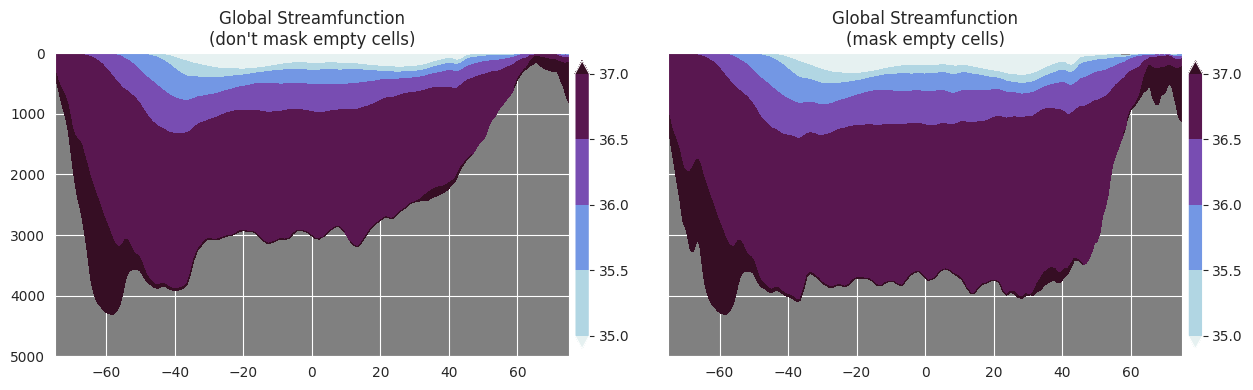

In [43]:
#define density levels
levels = [35, 35.5, 36, 36.5, 37]
GEOLAT, SIGMA2_L = np.meshgrid(psi["geolat"], psi["sigma2_l"])

#select experiment 
exp = "control"

# create one figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=True)

# first subplot: depth
ax = axes[0]
p1 = ax.contourf(GEOLAT, psi["depth"].sel(exp = exp), SIGMA2_L, 
                 cmap = cmo.dense, 
                 levels = [35, 35.5, 36, 36.5, 37], 
                 extend = "both")

c1 = fig.colorbar(p1, ax=ax, pad=0.01, spacing='uniform',
                  extend='both', shrink=0.95, orientation='vertical')
c1.set_ticks(levels)
c1.ax.tick_params(labelsize=10)
ax.set_facecolor('gray')
ax.set_xlim(-75, 75)
ax.set_ylim(0, 5000)
ax.invert_yaxis()
ax.set_title("Global Streamfunction\n(don't mask empty cells)")

# second subplot: depth_masked
ax = axes[1]
p2 = ax.contourf(GEOLAT, psi["depth_masked"].sel(exp = exp), SIGMA2_L, 
                 cmap = cmo.dense, 
                 levels = [35, 35.5, 36, 36.5, 37], 
                 extend = "both")

c2 = fig.colorbar(p2, ax=ax, pad=0.01, spacing='uniform',
                  extend='both', shrink=0.95, orientation='vertical')
c2.set_ticks(levels)
c2.ax.tick_params(labelsize=10)
ax.set_facecolor('gray')
ax.set_xlim(-75, 75)
ax.set_ylim(0, 5000)
ax.invert_yaxis()
ax.set_title("Global Streamfunction\n(mask empty cells)")

fig.tight_layout()

[]

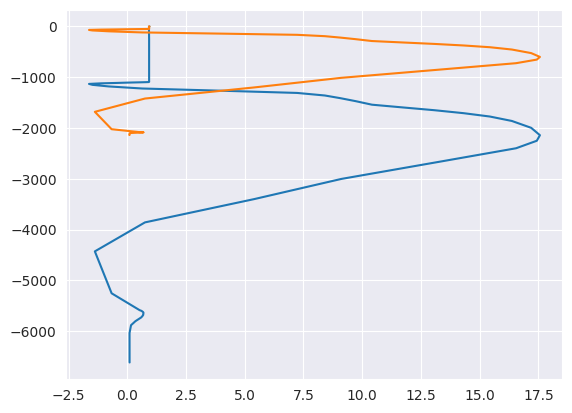

In [92]:
lat_yq_idx = 146
psi_lat = psi.isel(exp = 0).sel(yq = lat_yq_idx, method = "nearest")
plt.plot(psi_lat, -psi_lat["depth_masked"])
plt.plot(psi_lat, -psi_lat["depth"], label = "depth")
plt.plot()